# import the necessary packages

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import time
from torch.utils.data import Subset, DataLoader
from typing import List, Tuple
import os
from torch.optim.lr_scheduler import _LRScheduler
import tracemalloc
from enum import Enum
from sklearn.model_selection import StratifiedKFold
import copy
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# MLP

## Parameter settings

In [35]:

# define the enums for hyperparameters
class NumOfHiddenLayer(Enum):
    THREE = 3
    FOUR = 4
    FIVE = 5

class LearningRateScheduler(Enum):
    FIXED = 'None'
    StepLR = 'StepLR'
    CosineAnnealingLR = 'CosineAnnealingLR'
    ReduceLROnPlateau = 'ReduceLROnPlateau'

class ActivationFunction(Enum):
    ReLU = "ReLU"
    LeakyReLU = "LeakyReLU"
    ELU = "ELU"

class Optimizer(Enum):
    SGD = 'SGD'
    Adam = 'Adam'
    RMSprop = 'RMSprop'

class BatchNormalization(Enum):
    True_ = True
    False_ = False

class Regularization(Enum):
    L1 = 'L1'
    L2 = 'L2'
    None_ = None

class Augmentation(Enum):
    True_ = True
    False_ = False

aug_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),         # rotate 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # translate
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),  # add gaussian noise
    transforms.Normalize((0.1307,), (0.3081,))
])  
# define the hyperparameters
num_of_hidden_layer = NumOfHiddenLayer.THREE
# hidden_sizes = [32, 32, 32]
# hidden_sizes = [64, 64, 64]
hidden_sizes = [128, 128, 128]
learning_rate_scheduler = LearningRateScheduler.StepLR
activation_function = ActivationFunction.ELU
optimizer = Optimizer.SGD
batch_normalization = BatchNormalization.True_
regularization = Regularization.L1
llambda = 1e-5
dropout = [0.25, 0.25, 0.0]
batch_size = 128
num_epochs = 200
lr = 0.1
augmentation = Augmentation.False_

## download EMNIST dataset and normalize the data

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # EMNIST normalized
])
# Load the training dataset of EMNIST with specified transformations
train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
# Load the test dataset of EMNIST with specified transformations
test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
# Print information about the training dataset

print(train_dataset)

print(test_dataset)
# Print information about the test dataset

Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset EMNIST
    Number of datapoints: 18800
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## plot the data

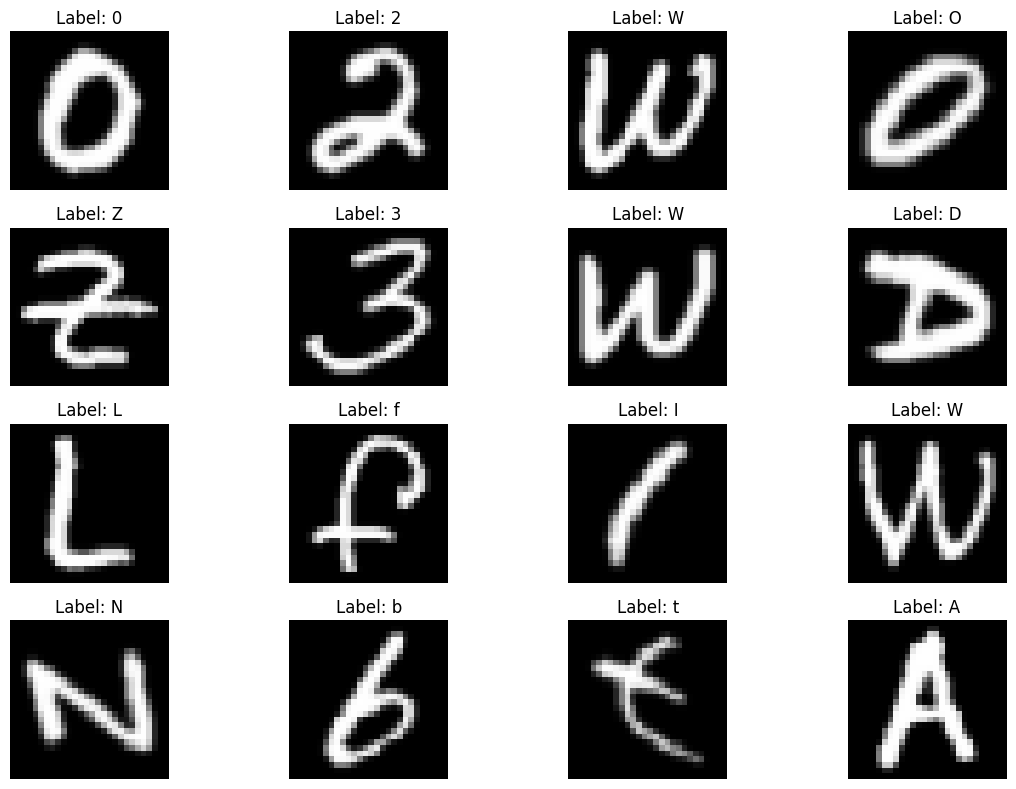

In [37]:
def plot_images(dataset, num_samples=16, cols=4):
    """plot a portion of the sample in the dataset"""
    # samples are selected at random
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    images = [dataset[i][0].squeeze().numpy() for i in indices]  # remove the channel dimension
    labels = [dataset.classes[dataset[i][1]] for i in indices]   # get the tag name

    # set up the canvas
    rows = num_samples // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 2 * rows))
    axes = axes.flatten()

    # draw an image
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.T, cmap='gray')  # note emnist images need to be transposed
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images(train_dataset)

## Define the MLP model

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(
        self, input_size: int = 28*28, # input size for EMNIST
        hidden_sizes: List[int] = [128, 128, 128], # 3 hidden layers
        num_classes: int = 47, # EMNIST has 47 classes
        activation_fn: nn.Module = nn.ReLU, # default activation function
        batch_normalization: bool = True, # use batch normalization
        dropout: List[float] = None, # dropout rates for each layer
    ) -> None: 
        super(MLP, self).__init__()
        self.net = nn.Sequential() # create a sequential model
        all_layes_sizes = [input_size] + hidden_sizes + [num_classes] # input size + hidden layers + output size
        for i in range(len(all_layes_sizes)-2): # iterate through the layers
            self.net.add_module(
                f"fc{i}", 
                nn.Linear(all_layes_sizes[i], all_layes_sizes[i+1])
            )  # fully connected layer
            if batch_normalization: # add batch normalization
                self.net.add_module(f"bn{i}", nn.BatchNorm1d(all_layes_sizes[i+1]))
            self.net.add_module(f"activation{i}", activation_fn()) # activation function
            if dropout is not None and dropout[i] > 1e-4: # add dropout
                self.net.add_module(f"dropout{i}", nn.Dropout(dropout[i]))
        self.net.add_module("output", nn.Linear(all_layes_sizes[-2], all_layes_sizes[-1])) # output layer
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # forward pass
        x = x.view(x.size(0), -1) 
        return self.net(x)

## define the function to train model

In [38]:
# Define the training function
def trainMLP(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: Optimizer, scheduler: _LRScheduler, criterion: nn.Module, num_epochs: int, device: torch.device, model_path: str = 'best_model.pth') -> Tuple[List[float], List[float], List[float], List[float], List[float], List[float], List[float], List[float]]:
    model.to(device)
    best_val_loss = float('inf')
    best_val_acc = 0
    best_train_loss = float('inf')
    best_train_acc = 0
    train_loss_list = [] # list to store training loss
    val_loss_list = [] # list to store validation loss
    train_acc_list = [] # list to store training accuracy
    val_acc_list = [] # list to store validation accuracy
    num_of_no_improvement = 0 # number of epochs without improvement
    for epoch in range(1, num_epochs + 1): # iterate through the epochs
        train_loss = 0 # initialize training loss
        correct = 0 # initialize correct predictions
        total = 0 # initialize total predictions
        model.train() # set the model to training mode
        
        epoch_start = time.time() # start the epoch timer

        for data, target in train_loader: # iterate through the training data
            data, target = data.to(device), target.to(device) # move data to device
            optimizer.zero_grad() # zero the gradients
            output = model(data) # forward pass
            loss = criterion(output, target) # calculate loss
            # add regularization
            if regularization == Regularization.L1:
                l1_lambda = 1e-5
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
            elif regularization == Regularization.L2:
                l2_lambda = 1e-4
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2_lambda * l2_norm
            loss.backward() # backward pass
            optimizer.step() # update weights
            train_loss += loss.item() * data.size(0) # accumulate training loss
            _, predicted = torch.max(output.data, 1) # get the predicted labels
            total += target.size(0) # accumulate total predictions
            correct += (predicted == target).sum().item() # accumulate correct predictions
        train_loss /= len(train_loader.dataset) # average training loss
        train_acc = correct / total # training accuracy
        train_acc_list.append(train_acc) # append training accuracy
        train_loss_list.append(train_loss) # append training loss
        # Validation
        val_loss = 0
        correct = 0
        total = 0
        model.eval()
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if learning_rate_scheduler == LearningRateScheduler.StepLR:
            scheduler.step()
        elif learning_rate_scheduler == LearningRateScheduler.ReduceLROnPlateau:
            scheduler.step(val_loss)

        if val_loss < best_val_loss: # check if validation loss improved
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_train_loss = train_loss
            best_train_acc = train_acc
            torch.save(model.state_dict(), model_path)
            num_of_no_improvement = 0
        else:
            num_of_no_improvement += 1
            if num_of_no_improvement >= 10: # early stopping
                print(f"Early stopping at epoch {epoch}")
                break
        epoch_end = time.time() # end the epoch timer
        epoch_duration = epoch_end - epoch_start # calculate epoch duration

        if torch.cuda.is_available():
            peak_mem = torch.cuda.max_memory_allocated(device) / 1024 / 1024  # MB
            torch.cuda.reset_peak_memory_stats(device)
        print(f"Epoch {epoch}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_duration:.2f}s, "
              f"Peak Memory: {peak_mem:.2f}MB" if torch.cuda.is_available() else "")
    return best_val_loss, best_val_acc, best_train_loss, best_train_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list

## start training the model

In [ ]:

result_file_path = './result.json' # path to save the results

k = 5
targets = train_dataset.targets.numpy() # get the targets
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # create stratified k-fold cross-validation
print("setup:\n"
      f"num_of_hidden_layer: {num_of_hidden_layer.value}, \n"
      f"hidden_sizes: {hidden_sizes}, \n"
      f"learning_rate: {lr}, \n"
      f"learning_rate_scheduler: {learning_rate_scheduler.value}, \n"
      f"optimizer: {optimizer.value}, \n"
      f"activation_function: {activation_function.value}, \n"
      f"batch_normalization: {batch_normalization.value}, \n"
      f"regularization: {regularization.value}, \n"
      f"llamada: {llambda}, \n"
      f"dropout: {dropout}, \n"
      f"augmentation: {augmentation.value}, \n"
      f"num_of_epochs: {num_epochs}, \n"
      f"batch_size: {batch_size}, \n"
      f"num_of_folds: {skf.n_splits}, \n"
      f"augmentation: {augmentation.value}, \n"
      f"train_dataset_size: {len(train_dataset)}, \n"
      f"test_dataset_size: {len(test_dataset)}")
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\nFold {fold+1}')
    model_path = f'./models/best_model_fold_{fold+1}-{k}_num-of-hidden-layer_{num_of_hidden_layer.value}_hidden-sizes_{hidden_sizes}_lr_{lr}_scheduler_{learning_rate_scheduler.value}_optimizer_{optimizer.value}_activation_function_{activation_function.value}_batch_normalization_{batch_normalization.value}_regularization_{regularization.value}_llambda_{llambda}_dropout_{dropout}.pth' # path to save the model
    if augmentation == Augmentation.True_:
        model_path = model_path.replace('.pth', '_aug.pth')
    if os.path.exists(model_path):
        print(f"Model already exists at {model_path}, skipping training.")
        # break
        # continue
    # create the data loaders
    train_subset = Subset(train_dataset, train_idx) 
    val_subset = Subset(train_dataset, val_idx)
    train_subset.dataset = copy.deepcopy(train_dataset)
    val_subset.dataset = copy.deepcopy(train_dataset)
    if augmentation == Augmentation.True_:
        train_subset.dataset.transform = aug_transform

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    model = MLP(
        input_size=28*28, 
        hidden_sizes=hidden_sizes, 
        num_classes=47, 
        activation_fn=getattr(nn, activation_function.value),
        batch_normalization=batch_normalization.value, 
        dropout=dropout,
    )
    # set the optimizer
    if optimizer == Optimizer.SGD:
        optimizer_copy = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer == Optimizer.Adam:
        optimizer_copy = optim.Adam(model.parameters(), lr=lr)
    elif optimizer == Optimizer.RMSprop:
        optimizer_copy = optim.RMSprop(model.parameters(), lr=lr, alpha=0.9, momentum=0.9)
    if learning_rate_scheduler == LearningRateScheduler.StepLR:
        scheduler = optim.lr_scheduler.StepLR(optimizer_copy, step_size=10, gamma=0.5)
    elif learning_rate_scheduler == LearningRateScheduler.ReduceLROnPlateau:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_copy, mode='min', factor=0.1, patience=5, verbose=True)
    else:
        scheduler = None
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    tracemalloc.start()

    best_val_loss, best_val_acc, best_train_loss, best_train_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list = trainMLP(
        model, 
        train_loader, 
        val_loader, 
        optimizer_copy, 
        scheduler, 
        criterion, 
        num_epochs=num_epochs, 
        device=device, 
        model_path=model_path
    )
    
    end_time = time.time()
    train_duration = end_time - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f"Training time: {train_duration:.2f} seconds")
    print(f"Peak memory usage: {peak / 1024 / 1024:.2f} MB")    

    new_result = {
        "type": "MLP",
        "num_of_hidden_layer": num_of_hidden_layer.value,
        "hidden_sizes": hidden_sizes,
        "learning_rate": lr,
        "learning_rate_scheduler": learning_rate_scheduler.value,
        "optimizer": optimizer.value,
        "activation_function": activation_function.value,
        "batch_normalization": batch_normalization.value,
        "regularization": regularization.value,
        "llambda": llambda,
        "dropout": dropout,
        "augmentation": augmentation.value,
        "num_of_epochs": num_epochs,
        "batch_size": batch_size,
        "num_of_folds": skf.n_splits,
        "train_dataset_size": len(train_dataset),
        "test_dataset_size": len(test_dataset),
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_train_acc": best_train_acc,
        "train_loss_list": train_loss_list,
        "val_loss_list": val_loss_list,
        "train_acc_list": train_acc_list,
        "val_acc_list": val_acc_list,
        "model_path": model_path,
        "fold": fold + 1,
        "num_of_folds": k,
    }
    if os.path.exists(result_file_path):
        with open(result_file_path, "r") as result_file:
            data = json.load(result_file)
    else:
        data = []
    data.append(new_result)
    with open(result_file_path, "w") as result_file:
        json.dump(data, result_file, indent=4)
    print(f"Results saved to {result_file_path}")
    # break

setup:
num_of_hidden_layer: 3, 
hidden_sizes: [128, 128, 128], 
learning_rate: 0.1, 
learning_rate_scheduler: StepLR, 
optimizer: SGD, 
activation_function: ELU, 
batch_normalization: True, 
regularization: L1, 
llamada: 1e-05, 
dropout: [0.25, 0.25, 0.0], 
augmentation: True, 
num_of_epochs: 200, 
batch_size: 128, 
num_of_folds: 5, 
augmentation: True, 
train_dataset_size: 112800, 
test_dataset_size: 18800

Fold 1
Model already exists at ./models/best_model_fold_1-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0]_aug.pth, skipping training.
Epoch 1/200, Train Loss: 2.0148, Train Acc: 0.4345, Val Loss: 0.9182, Val Acc: 0.7142, Time: 57.32s, Peak Memory: 26.98MB
Epoch 2/200, Train Loss: 1.5101, Train Acc: 0.5664, Val Loss: 0.7449, Val Acc: 0.7671, Time: 56.98s, Peak Memory: 26.98MB
Epoch 3/200, Train Loss: 1.3724, Train Acc: 0.6062, Val Loss

## eval the model and plot the results

In [ ]:
import torch
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from typing import List

def visualize_ig(model: nn.Module, 
                 test_loader: torch.utils.data.DataLoader, 
                 index: int = 0, 
                 device: str = 'cpu') -> None:
    """
    Visualize the Integrated Gradients for a specific sample in the test set.
    """
    model.to(device)
    model.eval()

    # Get the sample from the test set
    inputs, labels = next(iter(test_loader))
    input_tensor = inputs[index].unsqueeze(0).to(device)  # [1, 1, 28, 28]
    label = labels[index].item()

    # Flatten the input tensor
    input_tensor_flat = input_tensor.view(1, -1).requires_grad_(True)

    # Forward pass to get the model's prediction
    with torch.no_grad():
        output = model(input_tensor_flat)
    predicted_class = output.argmax(dim=1).item()

    # Compute Integrated Gradients
    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(
        input_tensor_flat,
        target=predicted_class,
        return_convergence_delta=True
    )

    # Visualize the attributions
    attribution_image = attributions.view(28, 28).detach().cpu().numpy().T
    input_image = input_tensor.view(28, 28).cpu().numpy().T

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(input_image, cmap='gray')
    axs[0].set_title(f'Input Image')
    axs[0].axis('off')

    axs[1].imshow(attribution_image, cmap='hot')
    axs[1].set_title(f'IG Attribution')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


### eval the model on test set

Loading model from ./models/best_model_fold_1-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0].pth


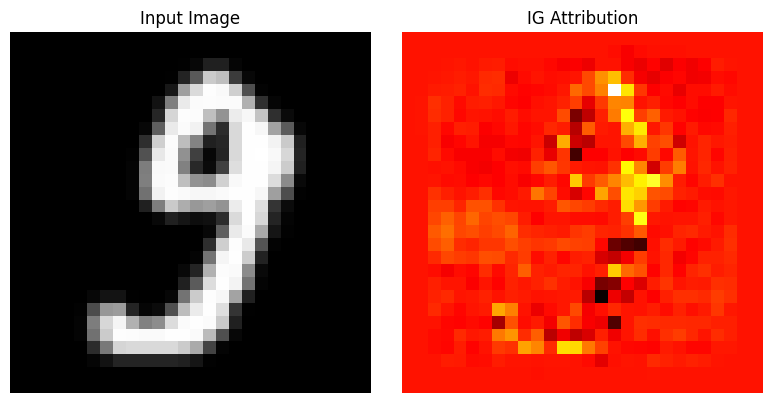

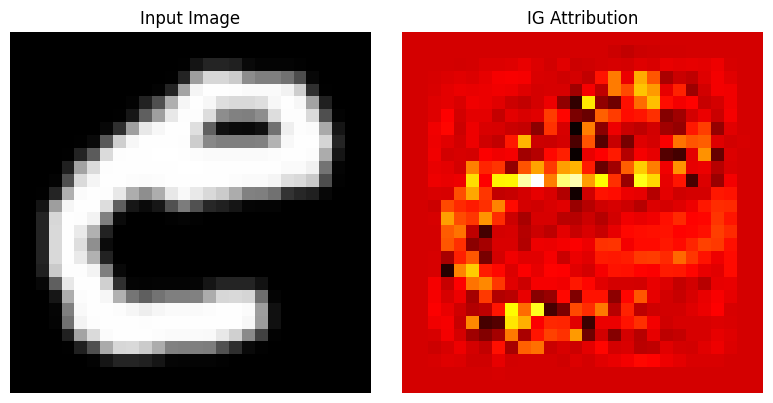

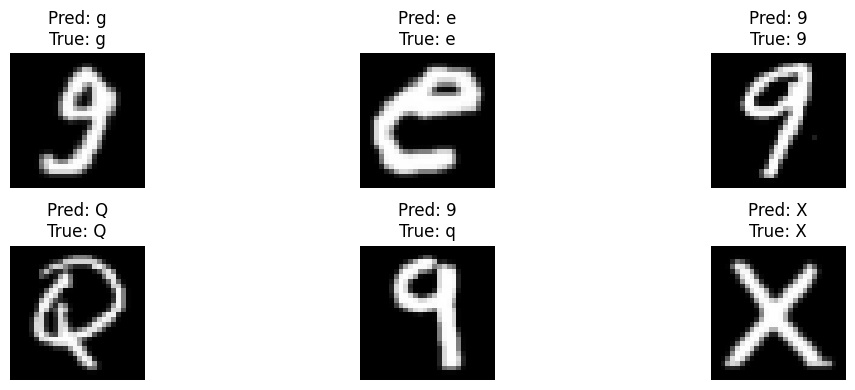

Precision: 0.8632
Recall: 0.8614
F1-score: 0.8598
Accuracy: 0.8614


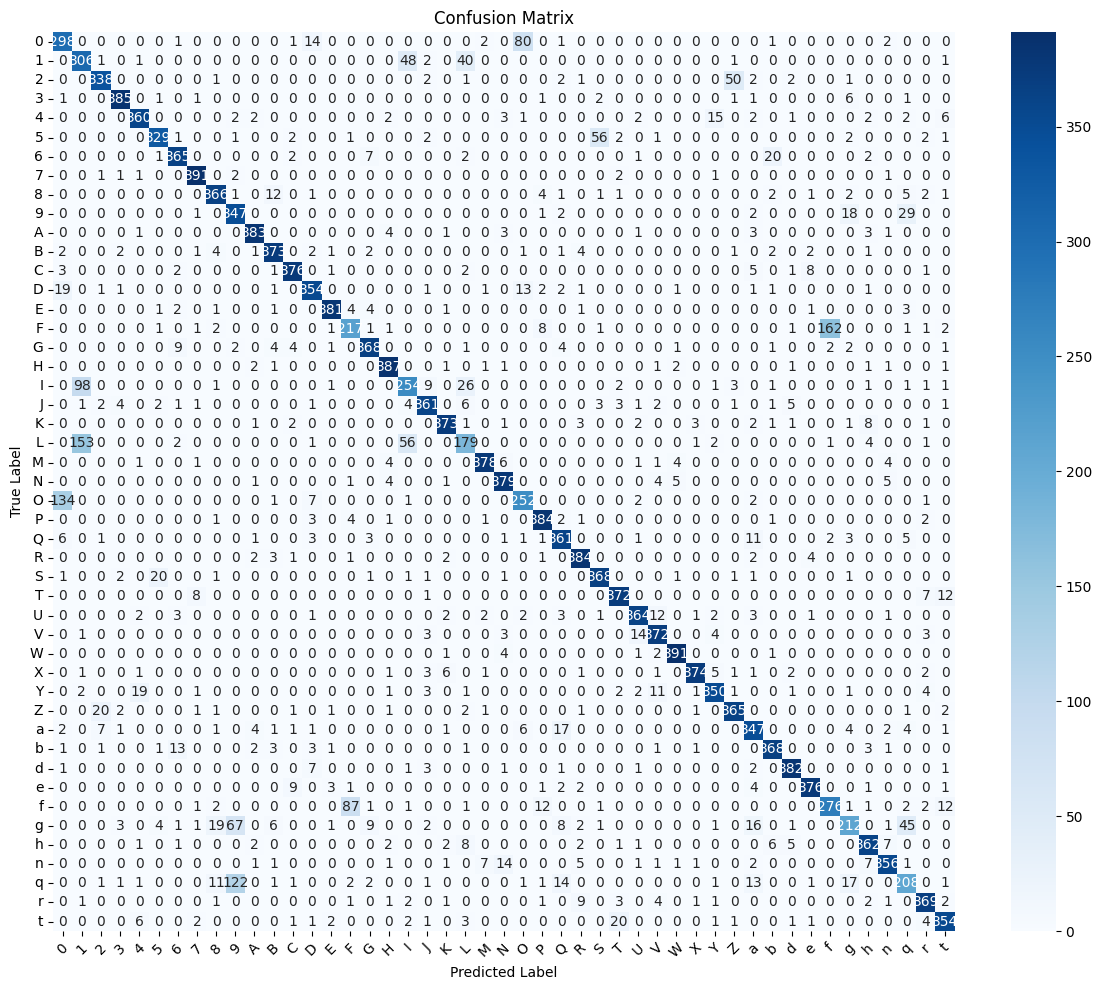

Loading model from ./models/best_model_fold_2-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0].pth


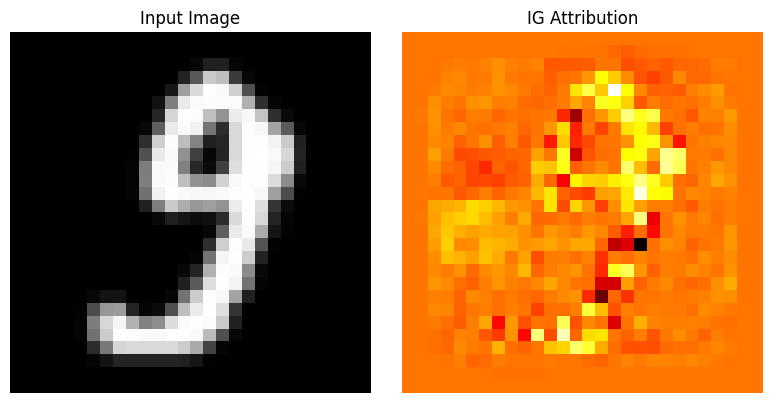

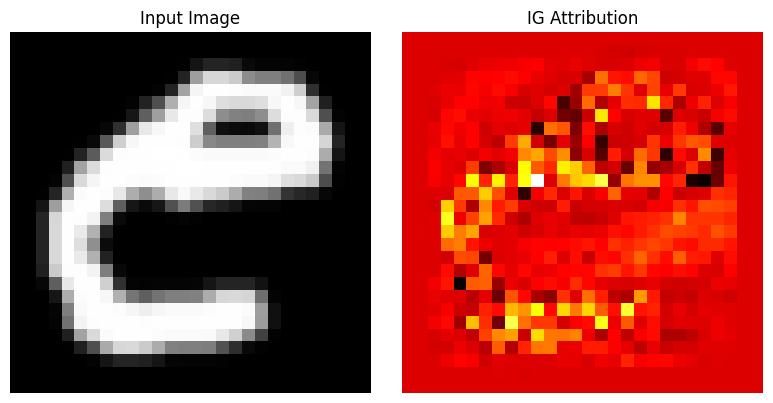

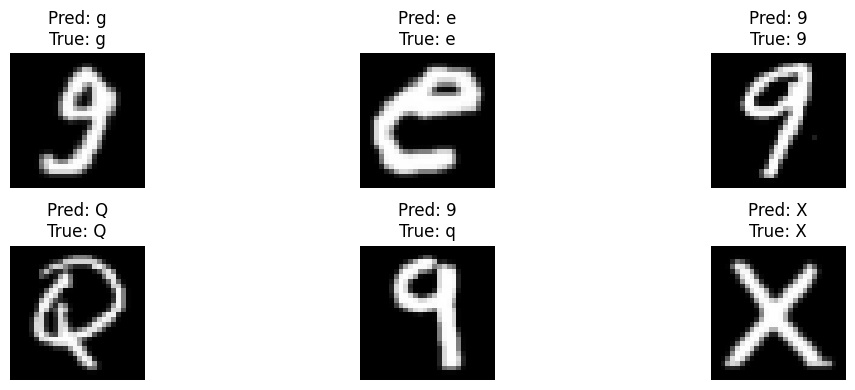

Precision: 0.8603
Recall: 0.8589
F1-score: 0.8575
Accuracy: 0.8589


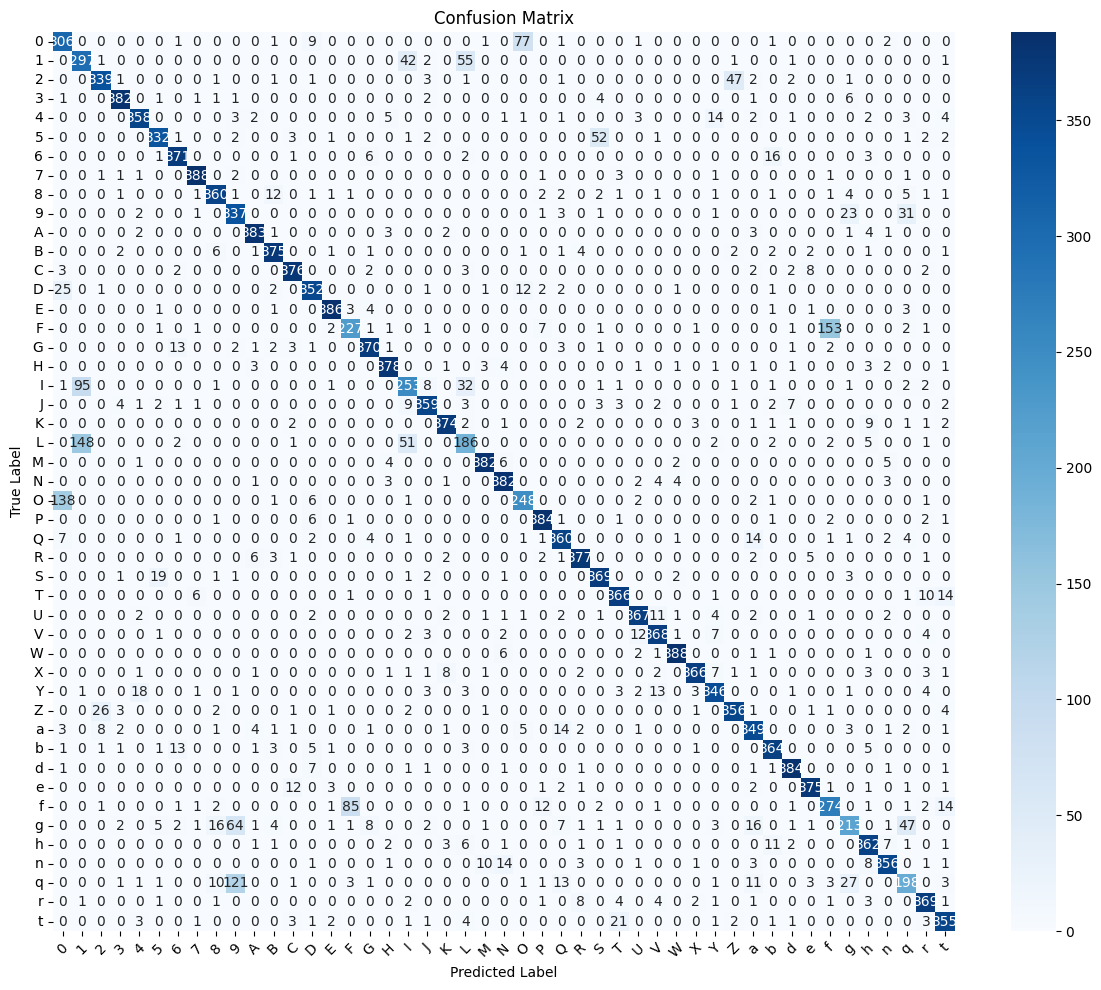

Loading model from ./models/best_model_fold_3-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0].pth


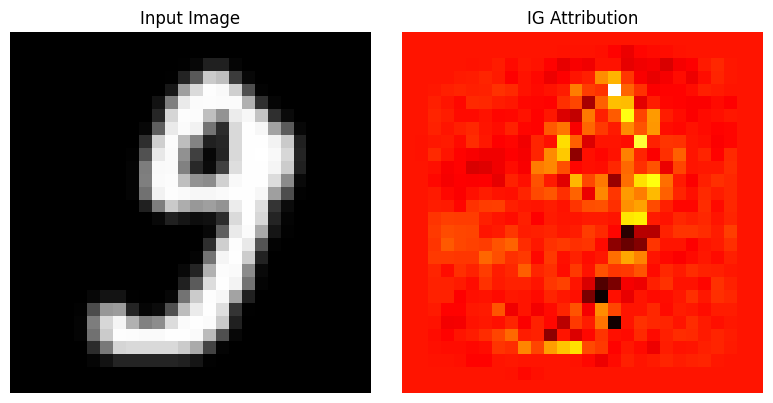

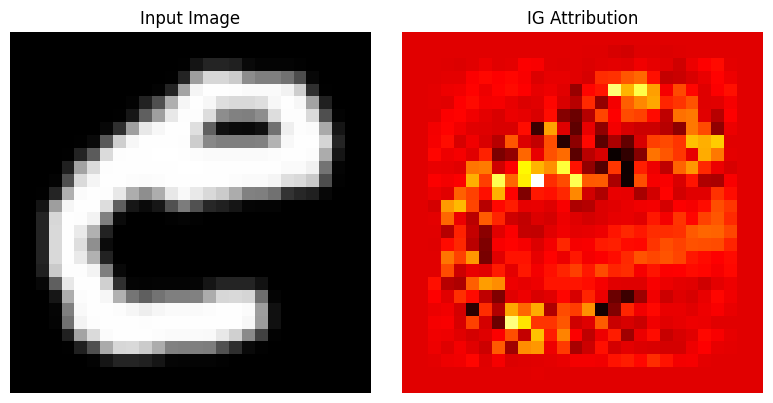

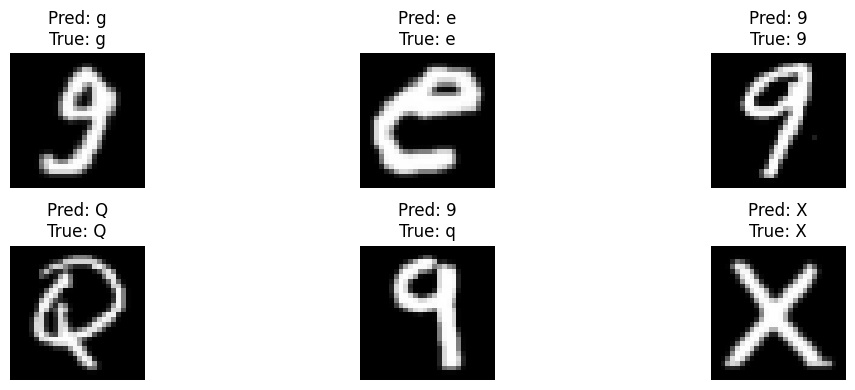

Precision: 0.8617
Recall: 0.8600
F1-score: 0.8585
Accuracy: 0.8600


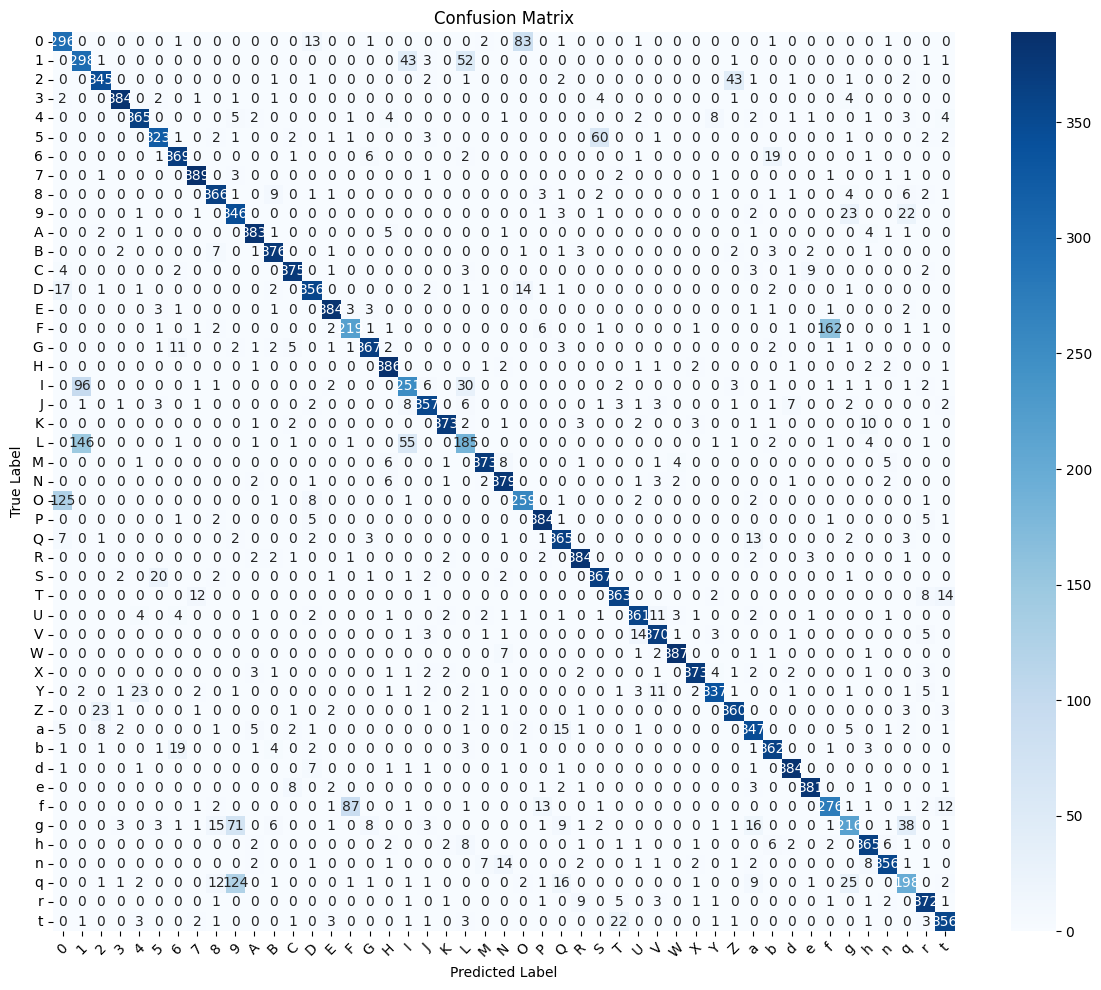

Loading model from ./models/best_model_fold_4-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0].pth


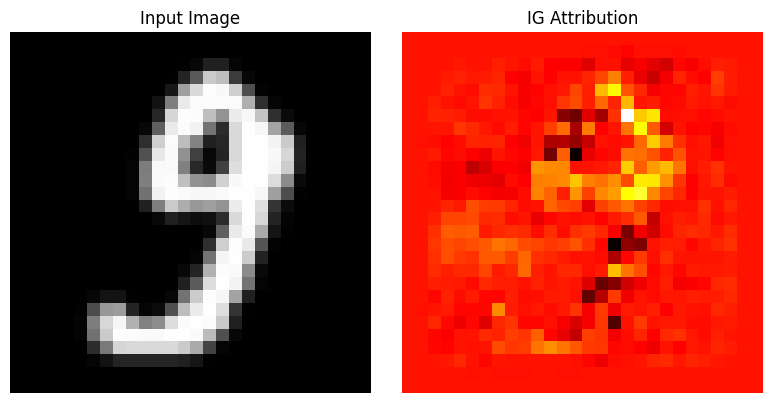

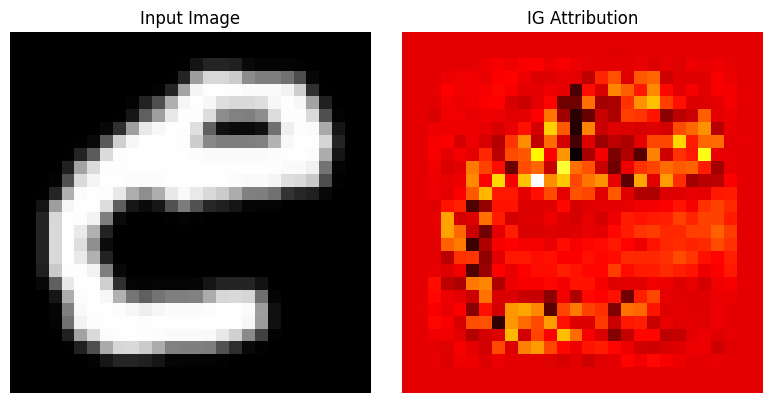

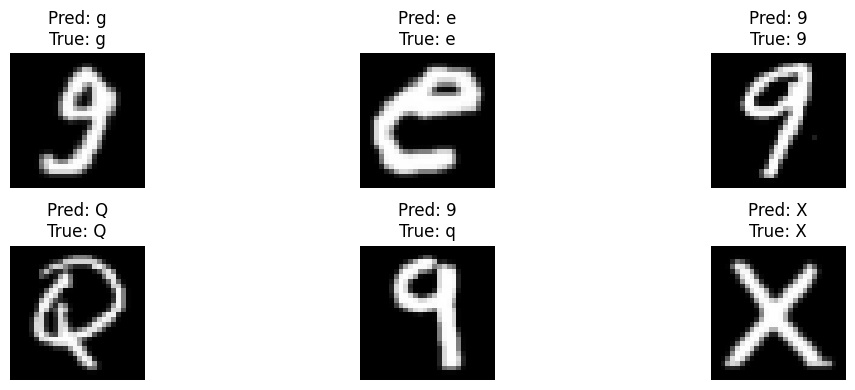

Precision: 0.8636
Recall: 0.8607
F1-score: 0.8593
Accuracy: 0.8607


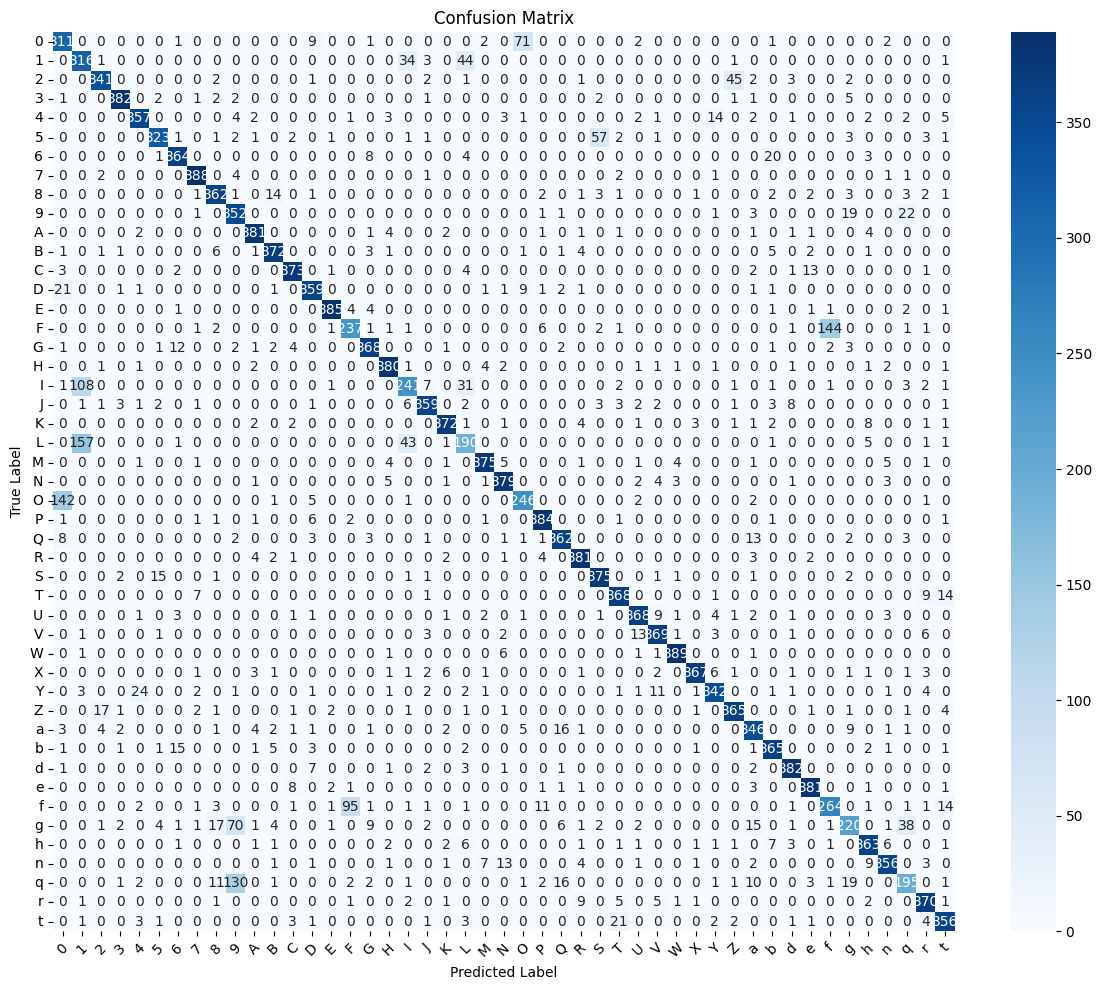

Loading model from ./models/best_model_fold_5-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0].pth


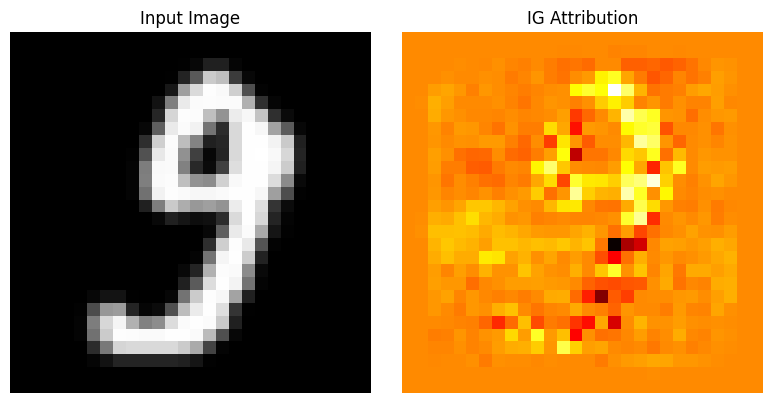

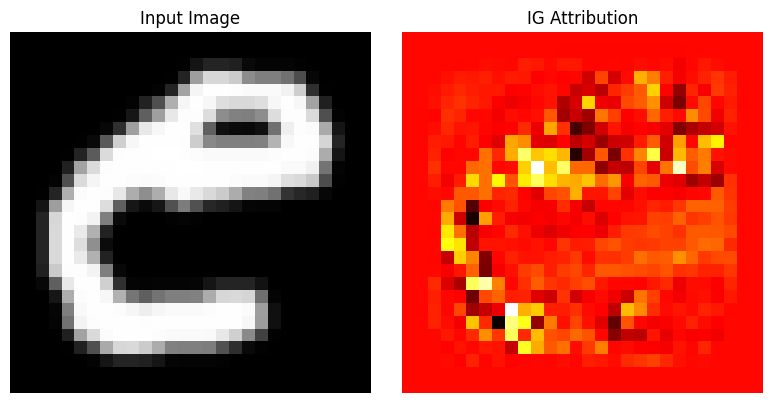

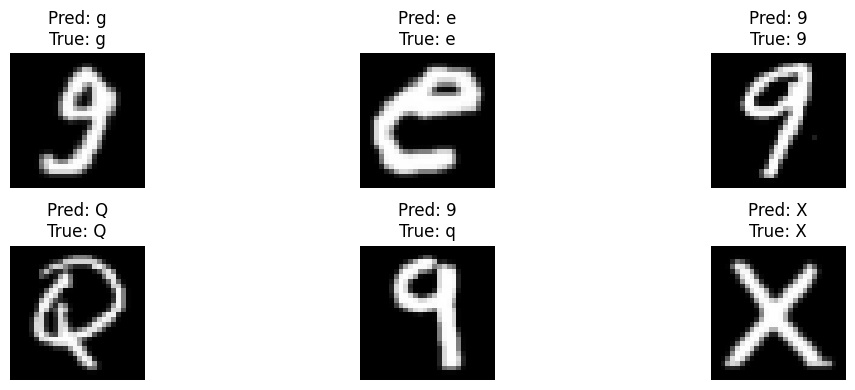

Precision: 0.8622
Recall: 0.8610
F1-score: 0.8595
Accuracy: 0.8610


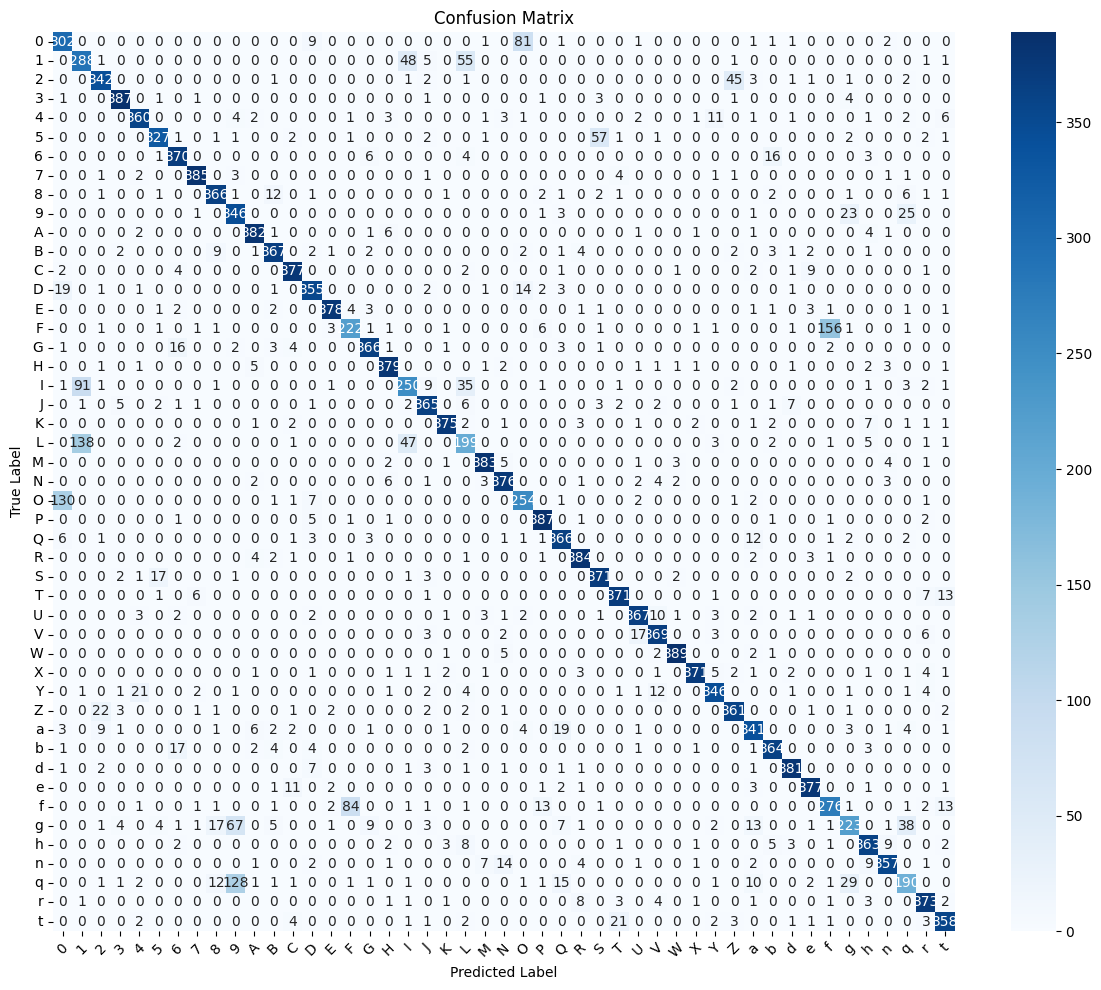

Average accuracy: 0.8604 ± 0.0009


In [ ]:
# define the hyperparameters
num_of_hidden_layer_test = NumOfHiddenLayer.THREE
# hidden_sizes_test = [32, 32, 32]
# hidden_sizes_test = [64, 64, 64]
hidden_sizes_test = [128, 128, 128]
learning_rate_scheduler_test = LearningRateScheduler.StepLR
activation_function_test = ActivationFunction.ELU
optimizer_test = Optimizer.SGD
batch_normalization_test = BatchNormalization.True_
regularization_test = Regularization.L1
llambda_test = 1e-5
dropout_test = [0.25, 0.25, 0.0]
batch_size_test = 128
num_epochs_test = 200
lr_test = 0.1
augmentation_test = Augmentation.False_
k_test = 5

accuracy_list = []
for i in range(1, k_test+1):
    model_path_test = f'./models/best_model_fold_{i}-{k_test}_num-of-hidden-layer_{num_of_hidden_layer_test.value}_hidden-sizes_{hidden_sizes_test}_lr_{lr_test}_scheduler_{learning_rate_scheduler_test.value}_optimizer_{optimizer_test.value}_activation_function_{activation_function_test.value}_batch_normalization_{batch_normalization_test.value}_regularization_{regularization_test.value}_llambda_{llambda_test}_dropout_{dropout_test}.pth'
    if augmentation_test == Augmentation.True_:
        model_path_test = model_path_test.replace('.pth', '_aug.pth')
    print(f"Loading model from {model_path_test}")
    test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
    model_test = MLP(
        input_size=28*28, 
        hidden_sizes=hidden_sizes_test, 
        num_classes=47, 
        activation_fn=getattr(nn, activation_function_test.value),
        batch_normalization=batch_normalization_test.value, 
        dropout=dropout_test,
    )
    model_test.load_state_dict(torch.load(model_path_test))
    model_test.to(device)
    model_test.eval()
    all_preds = []
    all_labels = []
    all_indices = []
    # Visualize the Integrated Gradients for the first two samples
    visualize_ig(model_test, test_loader, index=0, device='cuda')
    visualize_ig(model_test, test_loader, index=1, device='cuda')

    # Evaluate the model on the test set
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_test(data)
            _, predicted = torch.max(output.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            
            start_idx = batch_idx * test_loader.batch_size
            batch_size = data.size(0)
            all_indices.extend(range(start_idx, start_idx + batch_size))

    # visualize the predictions
    def show_predictions(dataset, indices, preds, labels, num=6):
        plt.figure(figsize=(12, 4))
        for i in range(num):
            idx = indices[i]
            img, true_label = dataset[idx]
            img = img.squeeze().numpy()

            pred_label = preds[i]
            true_label_idx = labels[i]

            plt.subplot(2, 3, i + 1)
            plt.imshow(img.T, cmap='gray')  # EMNIST needs transpose
            plt.title(f"Pred: {dataset.classes[pred_label]}\nTrue: {dataset.classes[true_label_idx]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    show_predictions(test_dataset, all_indices, all_preds, all_labels)
    # calculate the precision, recall, f1-score, accuracy, and confusion matrix
    prcision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Precision: {prcision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    # print(f"Confusion Matrix:\n{cm}")
    # plot the confusion matrix
    labels = test_dataset.classes

    plt.figure(figsize=(12, 10))  # 图像大小
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    accuracy_list.append(accuracy)
    # print(f"Fold {i} - Accuracy: {accuracy:.4f}")
print(f"Average accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")

### get the average accuracy and loss for 5-fold cross-validation

In [28]:
import pandas as pd
with open('./result.json', "r") as result_file:
    data = json.load(result_file)
# print(str(hidden_sizes_test))
# print(type(df['hidden_sizes'][0]))
df = pd.DataFrame(data)
print(len(df))
print(regularization_test.value)
df['regularization'] = df['regularization'].apply(lambda x: x if x is not None else 'None')
df = df[(df['num_of_hidden_layer'] == num_of_hidden_layer_test.value) &
        (df['hidden_sizes'].apply(lambda x: x == hidden_sizes_test)) &
        (df['learning_rate'] == lr_test) &
        (df['learning_rate_scheduler'] == learning_rate_scheduler_test.value) &
        (df['optimizer'] == optimizer_test.value) &
        (df['activation_function'] == activation_function_test.value) &
        (df['batch_normalization'] == batch_normalization_test.value) &
        (df['regularization'] == str(regularization_test.value)) &
        (df['llambda'] == llambda_test) &
        (df['dropout'].apply(lambda x: x == dropout_test)) &
        (df['num_of_epochs'] == num_epochs_test) &
        (df['batch_size'] == batch_size_test)]
if augmentation_test == Augmentation.True_:
    df = df[df['augmentation'] == True]
display(df)
print(f'best_val_acc: {df["best_val_acc"].mean():.4f} ± {df["best_val_acc"].std():.4f}')
print(f'best_train_acc: {df["best_train_acc"].mean():.4f} ± {df["best_train_acc"].std():.4f}')
print(f'best_val_loss: {df["best_val_loss"].mean():.4f} ± {df["best_val_loss"].std():.4f}')
print(f'best_train_loss: {df["best_train_loss"].mean():.4f} ± {df["best_train_loss"].std():.4f}')


80
L1


,type,num_of_hidden_layer,hidden_sizes,learning_rate,learning_rate_scheduler,optimizer,activation_function,batch_normalization,regularization,llambda,...,best_val_acc,best_train_loss,best_train_acc,train_loss_list,val_loss_list,train_acc_list,val_acc_list,model_path,fold,augmentation
75,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.862500,0.871696,0.754023,"[2.0147551147650318, 1.5101367923384863, 1.372...","[0.9182358205741179, 0.7448513047069523, 0.698...","[0.43450797872340424, 0.5663674645390071, 0.60...","[0.7141843971631205, 0.7671099290780142, 0.769...",./models/best_model_fold_1-5_num-of-hidden-lay...,1,True
76,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.854388,0.866252,0.755995,"[2.022021838959227, 1.5088039722848445, 1.3682...","[0.9179278753327985, 0.7459404098226669, 0.677...","[0.4354166666666667, 0.5681515957446809, 0.605...","[0.714627659574468, 0.7597074468085107, 0.7789...",./models/best_model_fold_2-5_num-of-hidden-lay...,2,True
77,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.859087,0.868076,0.753746,"[2.013886464741213, 1.5113139942182716, 1.3731...","[0.9296624521837167, 0.7519723286865451, 0.682...","[0.43628102836879434, 0.5666999113475177, 0.60...","[0.7094858156028369, 0.7567375886524823, 0.769...",./models/best_model_fold_3-5_num-of-hidden-lay...,3,True
78,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.862323,0.873850,0.753047,"[2.0205735323276928, 1.507501195001264, 1.3733...","[0.8862028027257175, 0.7343015537194326, 0.675...","[0.4345633865248227, 0.5688386524822695, 0.608...","[0.7245124113475178, 0.7611702127659574, 0.775...",./models/best_model_fold_4-5_num-of-hidden-lay...,4,True
79,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.860993,0.871110,0.754266,"[2.0099740840019065, 1.498934241558643, 1.3672...","[0.899309892941874, 0.7243393173454501, 0.6500...","[0.43936170212765957, 0.5702460106382978, 0.60...","[0.7170212765957447, 0.7705673758865248, 0.786...",./models/best_model_fold_5-5_num-of-hidden-lay...,5,True


best_val_acc: 0.8599 ± 0.0033
best_train_acc: 0.7542 ± 0.0011
best_val_loss: 0.4023 ± 0.0062
best_train_loss: 0.8702 ± 0.0030


### plot the training and validation loss and accuracy

Fold 1


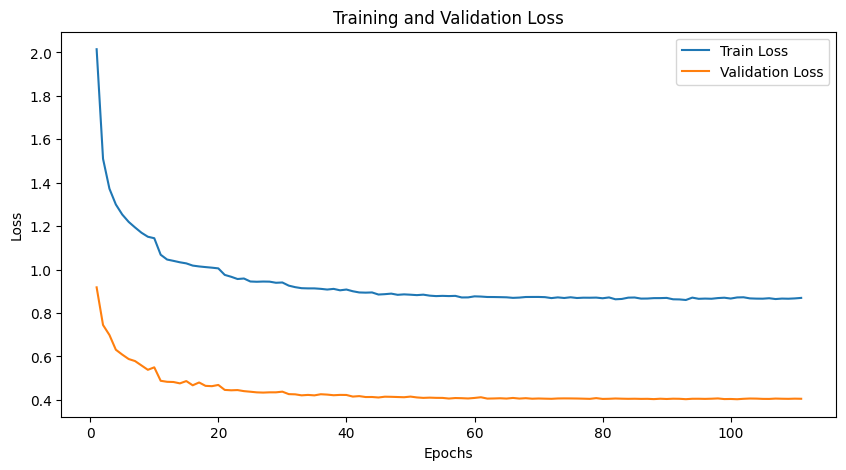

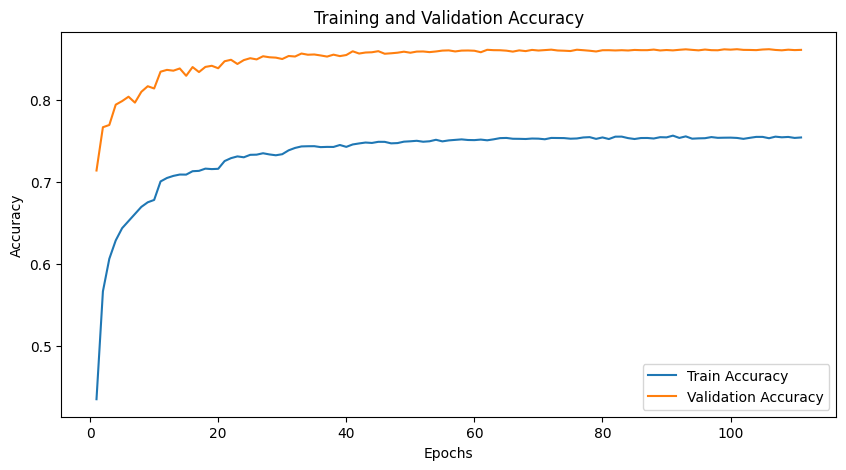

Fold 2


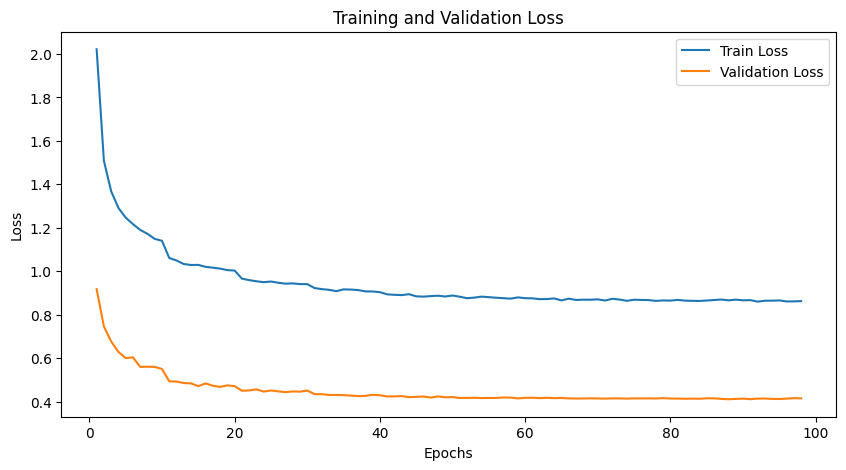

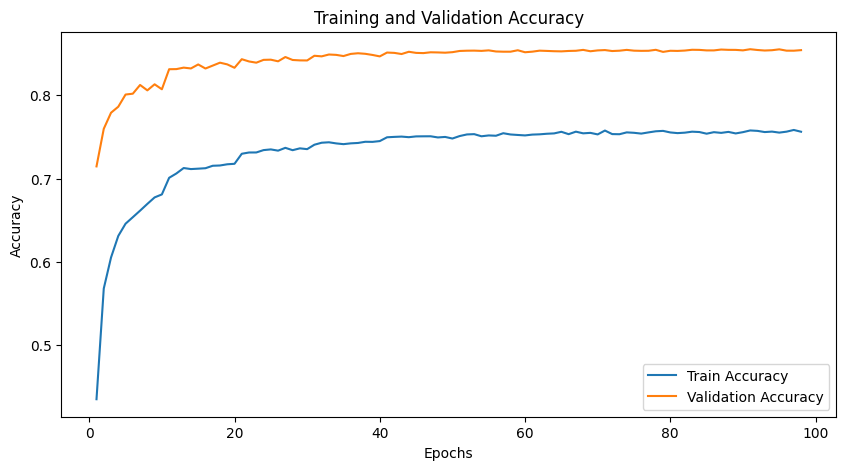

Fold 3


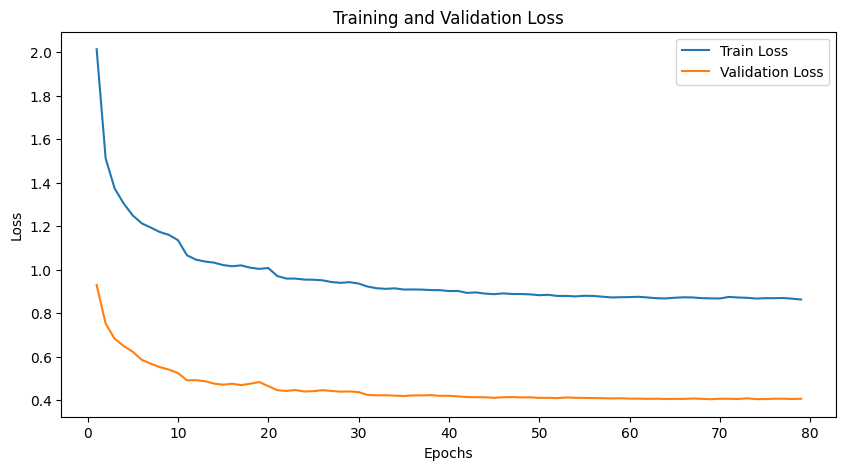

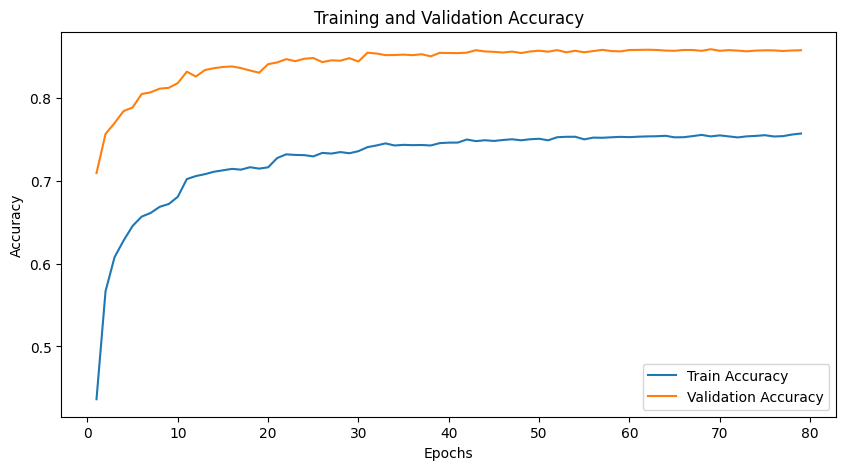

Fold 4


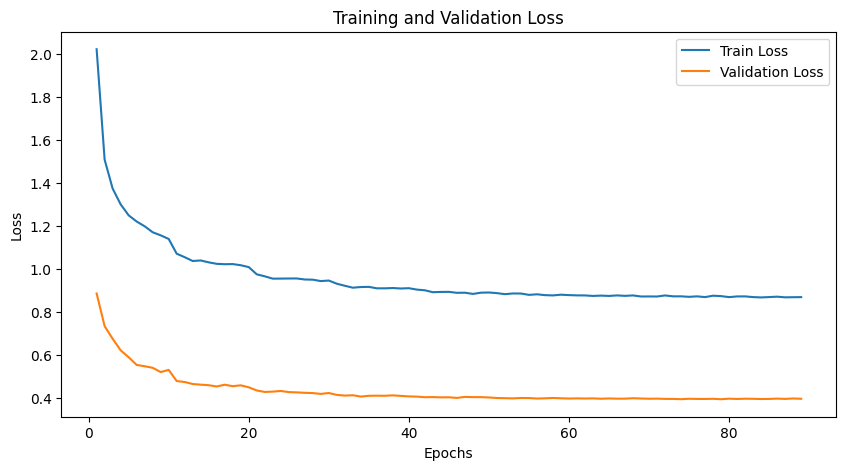

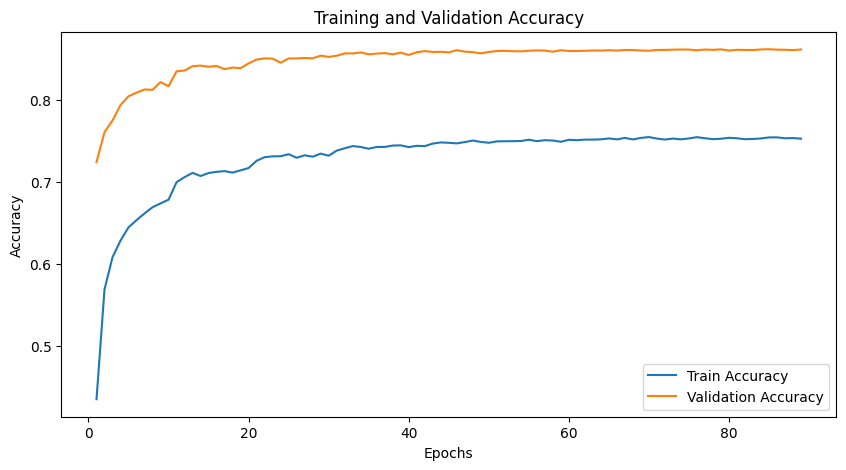

Fold 5


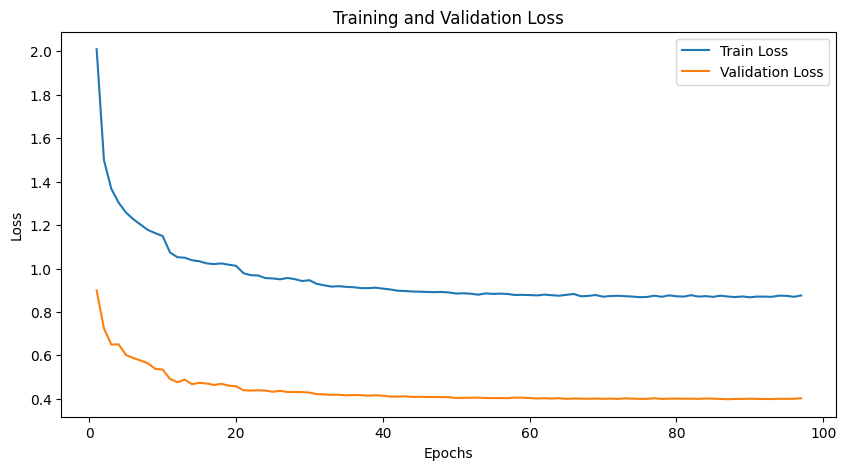

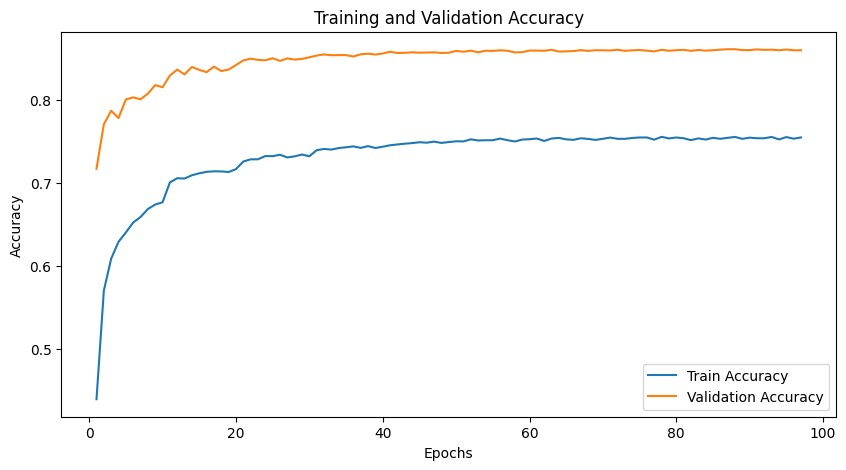

In [30]:
# plot the training and validation loss
def plot_loss(train_loss_list, val_loss_list, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
# plot the training and validation accuracy
def plot_accuracy(train_acc_list, val_acc_list, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

for i in range(1, k_test+1):
    print(f'Fold {i}')
    train_loss_list = df[df['fold'] == i]['train_loss_list'].values[0]
    val_loss_list = df[df['fold'] == i]['val_loss_list'].values[0]
    train_acc_list = df[df['fold'] == i]['train_acc_list'].values[0]
    val_acc_list = df[df['fold'] == i]['val_acc_list'].values[0]
    plot_loss(train_loss_list, val_loss_list, num_epochs_test)
    plot_accuracy(train_acc_list, val_acc_list, num_epochs_test)

# CNN TODO: lch

### Load and Preprocess Dataset

In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # EMNIST mean and std
])

# Custom dataset class for EMNIST Balanced
class EMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get image and label
        row = self.data.iloc[idx]
        label = row.iloc[0]  
        image = row.iloc[1:].values.reshape(28, 28).astype(np.uint8)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load EMNIST Balanced dataset
print("Loading EMNIST Balanced dataset...")
train_dataset = EMNISTDataset('./data/emnist-balanced-train.csv', transform=transform)
test_dataset = EMNISTDataset('./data/emnist-balanced-test.csv', transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(np.unique(train_dataset.data.iloc[:, 0]))}")
print(f"Image size: {train_dataset[0][0].shape}")
print(f"Sample label: {train_dataset[0][1]}")

### Visualize Dataset Samples

In [ ]:
def visualize_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

### Define CNN Model

In [ ]:
class EMNISTCNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU(), use_batch_norm=True, dropout_rate=0.5):
        super(EMNISTCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()
        self.act1 = activation_fn
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.act2 = activation_fn
        self.pool2 = nn.MaxPool2d(2)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.act3 = activation_fn
        self.fc2 = nn.Linear(128, 47)  # 47 classes in EMNIST Balanced
        
    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act3(self.fc1(x))
        x = self.fc2(x)
        return x

### Training and Evaluation Functions

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_model(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=10, regularization=0, weight_decay=0):
    model.train()
    train_losses = []
    train_accs = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            if regularization == 1:
                # l1 regularization
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += weight_decay * l1_norm
            elif regularization == 2:
                # l2 regularization
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += weight_decay * l2_norm
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    end_time = time.time()
    training_time = end_time - start_time
    memory_usage = psutil.Process().memory_info().rss / 1024 / 1024  # MB
    
    print(f'Training completed in {training_time:.2f} seconds')
    print(f'Memory usage: {memory_usage:.2f} MB')
    
    return train_losses, train_accs

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return all_preds, all_labels, accuracy

### Experiment with Different Configurations

In [ ]:
# set paras
activation_fns = [
    ('ReLU', nn.ReLU()),
    ('LeakyReLU', nn.LeakyReLU(0.1)),
    ('ELU', nn.ELU())
]

optimizers = [
    ('Adam', optim.Adam),
    ('SGD', optim.SGD),
    ('RMSprop', optim.RMSprop)
]

batch_norm_options = [True, False]
dropout_rates = [0.0, 0.5]
# L1 or L2 regularization, or without regularization
weight_decays = [0.0, 1e-2, 1e-2]

schedulers = [
    ('StepLR', optim.lr_scheduler.StepLR),
    #('ReduceLROnPlateau', optim.lr_scheduler.ReduceLROnPlateau),
    ('CosineAnnealingLR', optim.lr_scheduler.CosineAnnealingLR)
]

In [ ]:
# create model
def create_model(activation_fn, use_batch_norm, dropout_rate):
    return EMNISTCNN(
        activation_fn=activation_fn,
        use_batch_norm=use_batch_norm,
        dropout_rate=dropout_rate
    ).to(device)

def create_optimizer(model, optimizer_class, weight_decay=0.0):
    return optimizer_class(model.parameters(), lr=0.001, weight_decay=weight_decay)

def create_scheduler(optimizer, scheduler_class):
    if scheduler_class == optim.lr_scheduler.StepLR:
        return scheduler_class(optimizer, step_size=5, gamma=0.1)
    elif scheduler_class == optim.lr_scheduler.ReduceLROnPlateau:
        return scheduler_class(optimizer, mode='min', patience=2)
    else:  # CosineAnnealingLR
        return scheduler_class(optimizer, T_max=10)

In [ ]:
def cross_validate(model, dataset, k=5, batch_size=128, num_epochs=10, config=None):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'\nFold {fold + 1}/{k}')
        
        # Create data loaders for this fold
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        
        # Initialize model, optimizer, and scheduler for this fold
        model = create_model(
            config['activation_fn'],
            config['use_batch_norm'],
            config['dropout_rate']
        ).to(device)
        
        optimizer = create_optimizer(model, config['optimizer'])
        scheduler = create_scheduler(optimizer, config['scheduler'])
        
        # Train and evaluate
        criterion = nn.CrossEntropyLoss()
        train_losses, train_accs = train_model(
            model, train_loader, criterion, optimizer, scheduler, device, num_epochs
        )
        
        # Evaluate on validation set
        val_preds, val_labels, _ = evaluate_model(model, val_loader, device)
        val_accuracy = 100 * sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
        
        fold_results.append({
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_accuracy': val_accuracy
        })
    
    # Calculate average validation accuracy across folds
    avg_val_accuracy = sum(result['val_accuracy'] for result in fold_results) / k
    print(f'\nAverage validation accuracy across {k} folds: {avg_val_accuracy:.2f}%')
    
    return fold_results, avg_val_accuracy

In [ ]:
def train_and_evaluate(config, kfold = False):
    print(f"\nTraining configuration: {config['name']}")
    
    # Perform cross-validation
    if kfold:
        fold_results, avg_val_accuracy = cross_validate(
            model=None,  # Model will be created inside the function
            dataset=train_dataset,
            k=5,
            batch_size=batch_size,
            num_epochs=10,
            config=config
        )
    else:
        fold_results = None
        avg_val_accuracy = None
    
    # Train final model on full training set
    final_model = create_model(
        config['activation_fn'],
        config['use_batch_norm'],
        config['dropout_rate']
    ).to(device)
    
    optimizer = create_optimizer(final_model, config['optimizer'])
    scheduler = create_scheduler(optimizer, config['scheduler'])
    
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = train_model(
        final_model, train_loader, criterion, optimizer, scheduler, device, num_epochs=10
    )
    
    # Evaluate on test set
    test_preds, test_labels, acc = evaluate_model(final_model, test_loader, device)
    
    return {
        'fold_results': fold_results,
        'avg_val_accuracy': avg_val_accuracy,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'acc': acc
    }

In [ ]:
# results
results = {}
best_accuracy = 0
best_config = None

# baseline model
baseline_config = {
    'name': 'Baseline',     
    'activation_fn': nn.ReLU(), # activation function: ReLU
    'optimizer': optim.Adam, # optimizer: Adam
    'use_batch_norm': True, # use batch normalization
    'dropout_rate': 0.5, # dropout rate: 0.5
    'weight_decay': 0.0, # no L1/L2 regularization
    'scheduler': optim.lr_scheduler.CosineAnnealingLR, # learning rate scheduler: CosineAnnealingLR
    'regulization': 0 # no regularization
}

In [ ]:

# Train and evaluate the baseline model
baseline_results = train_and_evaluate(baseline_config, kfold=True)
results['Baseline'] = baseline_results

best_accuracy = baseline_results['avg_val_accuracy']
best_config = baseline_config.copy()
best_config['name'] = 'Best Baseline'

current_config = baseline_config.copy()
current_config['name'] = 'Current Configuration'
current_config

In [ ]:
# define hyper paras
search_space = [
    {
        'param': 'activation_fn',
        'candidates': [fn for name, fn in activation_fns if name != 'ReLU'],
        'config_builder': lambda v, cfg: {
            'name': f'Activation: {v.__name__}',
            'activation_fn': v,
            'optimizer': optim.Adam,
            'use_batch_norm': True,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'scheduler': optim.lr_scheduler.CosineAnnealingLR,
            'regulization': 0
        }
    },
    {
        'param': 'scheduler',
        'candidates': [cls for name, cls in schedulers if name != 'StepLR'],
        'config_builder': lambda v, cfg: {
            'name': f'Scheduler: {v.__name__}',
            'activation_fn': cfg['activation_fn'],
            'optimizer': optim.Adam,
            'use_batch_norm': True,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'scheduler': v,
            'regulization': 0
        }
    },
    {
        'param': 'optimizer',
        'candidates': [cls for name, cls in optimizers if name != 'Adam'],
        'config_builder': lambda v, cfg: {
            'name': f'Optimizer: {v.__name__}',
            'activation_fn': cfg['activation_fn'],
            'optimizer': v,
            'use_batch_norm': True,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'scheduler': cfg['scheduler'],
            'regulization': 0
        }
    },
    {
        'param': 'use_batch_norm',
        'candidates': [v for v in batch_norm_options if v != True],
        'config_builder': lambda v, cfg: {
            'name': f'BatchNorm: {v}',
            'activation_fn': cfg['activation_fn'],
            'optimizer': cfg['optimizer'],
            'use_batch_norm': v,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'scheduler': cfg['scheduler'],
            'regulization': 0
        }
    },
    {
        'param': 'weight_decay',
        'candidates': [weight_decays[i] for i in range(1, len(weight_decays))],
        'config_builder': lambda v, cfg: {
            'name': f'Regularization: {v}',
            'activation_fn': cfg['activation_fn'],
            'optimizer': cfg['optimizer'],
            'use_batch_norm': cfg['use_batch_norm'],
            'dropout_rate': 0.5,
            'weight_decay': v,
            'scheduler': cfg['scheduler'],
            'regulization': weight_decays.index(v)
        }
    },
    {
        'param': 'dropout_rate',
        'candidates': [v for v in dropout_rates if v != 0.5],
        'config_builder': lambda v, cfg: {
            'name': f'Dropout: {v}',
            'activation_fn': cfg['activation_fn'],
            'optimizer': cfg['optimizer'],
            'use_batch_norm': cfg['use_batch_norm'],
            'dropout_rate': v,
            'weight_decay': cfg['weight_decay'],
            'scheduler': cfg['scheduler'],
            'regulization': cfg['regulization']
        }
    }
]

def search_best_param(param_name, candidates, current_config, best_config, config_builder):
    global best_accuracy
    for candidate in candidates:
        config = config_builder(candidate, current_config)
        results[config['name']] = train_and_evaluate(config, kfold=False)
        if results[config['name']]['acc'] > best_accuracy:
            best_accuracy = results[config['name']]['acc']
            best_config[param_name] = candidate
    current_config[param_name] = best_config[param_name]
    return current_config, best_config

# main loop
for search in search_space:
    current_config, best_config = search_best_param(
        search['param'],
        search['candidates'],
        current_config,
        best_config,
        search['config_builder']
    )

best_config

### Visualize Results

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for config_name, result in results.items():
    plt.plot(result['train_losses'], label=config_name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for config_name, result in results.items():
    plt.plot(result['train_accs'], label=config_name)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plot confusion matrix for the best performing model
best_model_name = f"best model"
cm = confusion_matrix(best_result['test_labels'], best_result['test_preds'])
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ResNet TODO: lch

### Define ResNet model

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation_fn=nn.ReLU(), use_batch_norm=True):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
        self.relu = activation_fn
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
        
        # Shortcut path
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class EMNISTResNet(nn.Module):
    def __init__(self, num_classes=47, activation_fn=nn.ReLU(), use_batch_norm=True, dropout_rate=0.5):
        super(EMNISTResNet, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.relu = activation_fn
        
        # Residual blocks
        self.layer1 = self.make_layer(64, 64, 2, stride=1, activation_fn=activation_fn, use_batch_norm=use_batch_norm)
        self.layer2 = self.make_layer(64, 128, 2, stride=2, activation_fn=activation_fn, use_batch_norm=use_batch_norm)
        self.layer3 = self.make_layer(128, 256, 2, stride=2, activation_fn=activation_fn, use_batch_norm=use_batch_norm)
        
        # Global average pooling and final fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def make_layer(self, in_channels, out_channels, num_blocks, stride, activation_fn, use_batch_norm):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, activation_fn, use_batch_norm))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, activation_fn=activation_fn, use_batch_norm=use_batch_norm))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

In [ ]:
def train_model(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=10, regularization=0, weight_decay=0):
    model.train()
    train_losses = []
    train_accs = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            if regularization == 1:
                # l1 regularization
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += weight_decay * l1_norm
            elif regularization == 2:
                # l2 regularization
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += weight_decay * l2_norm
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    end_time = time.time()
    training_time = end_time - start_time
    memory_usage = psutil.Process().memory_info().rss / 1024 / 1024  # MB
    
    print(f'Training completed in {training_time:.2f} seconds')
    print(f'Memory usage: {memory_usage:.2f} MB')
    
    return train_losses, train_accs

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return all_preds, all_labels, accuracy

# create model
def create_model(activation_fn, use_batch_norm, dropout_rate):
    return EMNISTResNet(
        num_classes=47,
        activation_fn=activation_fn,
        use_batch_norm=use_batch_norm,
        dropout_rate=dropout_rate
    ).to(device)

def create_optimizer(model, optimizer_class, weight_decay=0.0):
    return optimizer_class(model.parameters(), lr=0.001, weight_decay=weight_decay)

def create_scheduler(optimizer, scheduler_class):
    if scheduler_class == optim.lr_scheduler.StepLR:
        return scheduler_class(optimizer, step_size=5, gamma=0.1)
    elif scheduler_class == optim.lr_scheduler.ReduceLROnPlateau:
        return scheduler_class(optimizer, mode='min', patience=2)
    elif scheduler_class == optim.lr_scheduler.CosineAnnealingLR:
        return scheduler_class(optimizer, T_max=10)

def cross_validate(model, dataset, k=5, batch_size=128, num_epochs=10, config=None):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'\nFold {fold + 1}/{k}')
        
        # Create data loaders for this fold
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        
        # Initialize model, optimizer, and scheduler for this fold
        model = create_model(
            config['activation_fn'],
            config['use_batch_norm'],
            config['dropout_rate']
        ).to(device)
        
        optimizer = create_optimizer(model, config['optimizer'])
        scheduler = create_scheduler(optimizer, config['scheduler'])
        
        # Train and evaluate
        criterion = nn.CrossEntropyLoss()
        train_losses, train_accs = train_model(
            model, train_loader, criterion, optimizer, scheduler, device, num_epochs
        )
        
        # Evaluate on validation set
        val_preds, val_labels, _ = evaluate_model(model, val_loader, device)
        val_accuracy = 100 * sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
        
        fold_results.append({
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_accuracy': val_accuracy
        })
    
    # Calculate average validation accuracy across folds
    avg_val_accuracy = sum(result['val_accuracy'] for result in fold_results) / k
    print(f'\nAverage validation accuracy across {k} folds: {avg_val_accuracy:.2f}%')
    
    return fold_results, avg_val_accuracy
def train_and_evaluate(config, kfold = False):
    print(f"\nTraining configuration: {config['name']}")
    
    # Perform cross-validation
    if kfold:
        fold_results, avg_val_accuracy = cross_validate(
            model=None,  # Model will be created inside the function
            dataset=train_dataset,
            k=5,
            batch_size=batch_size,
            num_epochs=10,
            config=config
        )
    else:
        fold_results = None
        avg_val_accuracy = None
    
    # Train final model on full training set
    final_model = create_model(
        config['activation_fn'],
        config['use_batch_norm'],
        config['dropout_rate']
    ).to(device)
    
    optimizer = create_optimizer(final_model, config['optimizer'])
    scheduler = create_scheduler(optimizer, config['scheduler'])
    
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = train_model(
        final_model, train_loader, criterion, optimizer, scheduler, device, num_epochs=10
    )
    
    # Evaluate on test set
    test_preds, test_labels, acc = evaluate_model(final_model, test_loader, device)
    
    return {
        'fold_results': fold_results,
        'avg_val_accuracy': avg_val_accuracy,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'acc': acc
    }


In [ ]:
# set paras
activation_fns = [
    ('ReLU', nn.ReLU()),
    #('LeakyReLU', nn.LeakyReLU(0.1)),
    ('ELU', nn.ELU())
]

optimizers = [
    #('Adam', optim.Adam),
    ('SGD', optim.SGD),
    ('RMSprop', optim.RMSprop)
]

batch_norm_options = [True, False]
dropout_rates = [0.0, 0.5]
# L1 or L2 regularization, or without regularization
weight_decays = [0.0, 1e-2, 1e-2]

schedulers = [
    ('StepLR', optim.lr_scheduler.StepLR),
    #('ReduceLROnPlateau', optim.lr_scheduler.ReduceLROnPlateau),
    #('CosineAnnealingLR', optim.lr_scheduler.CosineAnnealingLR)
]

### Train and Evaluate Model

In [ ]:
# results
results = {}
best_accuracy = 0
best_config = None

# baseline model
baseline_config = {
    'name': 'Baseline',     
    'activation_fn': nn.LeakyReLU(), # activation function: LeakyRelu
    'optimizer': optim.Adam, # optimizer: Adam
    'use_batch_norm': True, # use batch normalization
    'dropout_rate': 0.5, # dropout rate: 0.5
    'weight_decay': 0.01, # L1 regularization
    'scheduler': optim.lr_scheduler.CosineAnnealingLR, # learning rate scheduler: CosineAnnealingLR
    'regulization': 1 
}

baseline_results = train_and_evaluate(baseline_config, kfold=True)
results['Baseline'] = baseline_results

best_accuracy = baseline_results['avg_val_accuracy']
best_config = baseline_config.copy()
best_config['name'] = 'Best Baseline'

current_config = baseline_config.copy()
current_config['name'] = 'Current Configuration'
current_config
best_result = results['Baseline'].copy()

In [ ]:
# hyper para search config
search_settings = [
    {
        'param': 'activation_fn',
        'candidates': [fn for name, fn in activation_fns],
        'skip': lambda v, i: False,
        'config': lambda v, cfg: dict(
            name=f'Activation: {v.__name__}',
            activation_fn=v,
            optimizer=optim.Adam,
            use_batch_norm=True,
            dropout_rate=0.5,
            weight_decay=0.01,
            scheduler=optim.lr_scheduler.CosineAnnealingLR,
            regulization=1
        )
    },
    {
        'param': 'scheduler',
        'candidates': [cls for name, cls in schedulers],
        'skip': lambda v, i: False,
        'config': lambda v, cfg: dict(
            name=f'Scheduler: {v.__name__}',
            activation_fn=cfg['activation_fn'],
            optimizer=optim.Adam,
            use_batch_norm=True,
            dropout_rate=0.5,
            weight_decay=0.01,
            scheduler=v,
            regulization=1
        )
    },
    {
        'param': 'optimizer',
        'candidates': [cls for name, cls in optimizers],
        'skip': lambda v, i: False,
        'config': lambda v, cfg: dict(
            name=f'Optimizer: {v.__name__}',
            activation_fn=cfg['activation_fn'],
            optimizer=v,
            use_batch_norm=True,
            dropout_rate=0.5,
            weight_decay=0.01,
            scheduler=cfg['scheduler'],
            regulization=1
        )
    },
    {
        'param': 'use_batch_norm',
        'candidates': batch_norm_options,
        'skip': lambda v, i: v == True,
        'config': lambda v, cfg: dict(
            name=f'BatchNorm: {v}',
            activation_fn=cfg['activation_fn'],
            optimizer=cfg['optimizer'],
            use_batch_norm=v,
            dropout_rate=0.5,
            weight_decay=0.01,
            scheduler=cfg['scheduler'],
            regulization=1
        )
    },
    {
        'param': 'weight_decay',
        'candidates': list(enumerate(weight_decays)),
        'skip': lambda v, i: v[0] == 1,
        'config': lambda vi, cfg: dict(
            name=f'Regularization: {vi[0]}',
            activation_fn=cfg['activation_fn'],
            optimizer=cfg['optimizer'],
            use_batch_norm=cfg['use_batch_norm'],
            dropout_rate=0.5,
            weight_decay=vi[1],
            scheduler=cfg['scheduler'],
            regulization=vi[0]
        )
    },
    {
        'param': 'dropout_rate',
        'candidates': dropout_rates,
        'skip': lambda v, i: v == 0.5,
        'config': lambda v, cfg: dict(
            name=f'Dropout: {v}',
            activation_fn=cfg['activation_fn'],
            optimizer=cfg['optimizer'],
            use_batch_norm=cfg['use_batch_norm'],
            dropout_rate=v,
            weight_decay=cfg['weight_decay'],
            scheduler=cfg['scheduler'],
            regulization=cfg['regulization']
        )
    }
]

def search_and_update(setting, current_config, best_config, best_accuracy, best_result):
    for i, candidate in enumerate(setting['candidates']):
        if setting['skip'](candidate, i):
            continue
        config = setting['config'](candidate, current_config)
        results[config['name']] = train_and_evaluate(config, kfold=False)
        if results[config['name']]['acc'] > best_accuracy:
            best_accuracy = results[config['name']]['acc']
            if setting['param'] == 'weight_decay':
                best_config['weight_decay'] = candidate[1]
                best_config['regulization'] = candidate[0]
            else:
                best_config[setting['param']] = candidate
            best_result = results[config['name']].copy()
    # update current_config
    if setting['param'] == 'weight_decay':
        current_config['weight_decay'] = best_config['weight_decay']
        current_config['regulization'] = best_config['regulization']
    else:
        current_config[setting['param']] = best_config[setting['param']]
    return current_config, best_config, best_accuracy, best_result

# main loop
for setting in search_settings:
    current_config, best_config, best_accuracy, best_result = search_and_update(
        setting, current_config, best_config, best_accuracy, best_result
    )

best_config

### Visualize Results

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for config_name, result in results.items():
    plt.plot(result['train_losses'], label=config_name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for config_name, result in results.items():
    plt.plot(result['train_accs'], label=config_name)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
best_model_name = f"Activate Func: {best_config[activation_fn]}, optimizer: {best_config[optimizer]}, BatchNorm: {best_config[regularization]}, Dropout: {best_config['dropout_rate']}, Regularization L{best_config['regulization']}"
cm = confusion_matrix(best_result['test_labels'], best_result['test_preds'])
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Print classification report for the best model
print(f"Classification Report - {best_model_name}")
print(classification_report(best_result['test_labels'], best_result['test_preds']))